# Advanced: Recovering the 12-6 Lennard-Jones Potential

This tutorial expands upon the previous 12-6 LJ tutorial.  Here, we will attempt to recover not only epsilon and sigma, but also the two exponents.

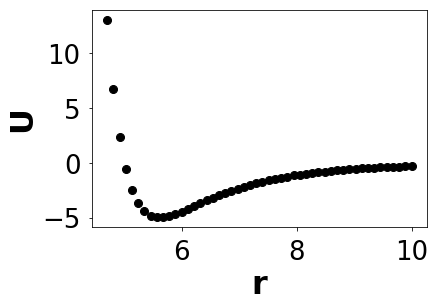

In [1]:
import numpy as np

from nanoparticle_optimization.forcefield import Mie, Parameter
from nanoparticle_optimization.target import Target

sigma_target = Parameter(value=5.0, fixed=True)
epsilon_target = Parameter(value=5.0, fixed=True)
n_target = Parameter(value=12.0, fixed=True)
m_target = Parameter(value=6.0, fixed=True)

mie_target = Mie(sigma=sigma_target, epsilon=epsilon_target, n=n_target, m=m_target)

'''
sep_low = np.linspace(4.7, 5.7, 50)[:-1]
sep_hi = np.linspace(5.7, 10, 50)
separations = np.hstack((sep_low, sep_hi))
target = Target(separations=separations, potential=potential)
'''

separations = np.linspace(4.7, 10.0, 50)
potential = mie_target.calc_potential(separations)
target = Target(separations=separations, potential=potential)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.xlabel('r')
plt.ylabel('U')

As in the previous tutorial we create a target potential of the 12-6 LJ form with sigma and epsilon values of 5.0.

In [5]:
import mbuild as mb

from nanoparticle_optimization.system import System

point_particle = mb.Compound(pos=np.zeros(3))
system = System(point_particle)

sigma = Parameter(value=2.5, upper=10.0, lower=2.0)
epsilon = Parameter(value=2.0, upper=10.0, lower=2.0)
n = Parameter(value=15.0, upper=25.0, lower=10.0)
m = Parameter(value=6.0, fixed=True)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

Again we define the `Forcefield` that we want to optimize.  However this time we are not setting `n` to be fixed.

In [6]:
from nanoparticle_optimization.optimization import Optimization

optimization = Optimization(ff, system, target, configurations=1, verbose=True)
optimization.driver()

##############################################
Setup: Checking root problem for potential issues...

No recorders have been specified, so no data will be saved.

Setup: Check of root problem complete.
##############################################

Current values:
n:	15.0
epsilon:	2.0
sigma:	2.5
Residual:	0.9850705330259608

Current values:
n:	15.0
epsilon:	2.0
sigma:	2.5
Residual:	0.9850705330259608

Current values:
n:	22.5
epsilon:	2.0
sigma:	2.5
Residual:	0.989236485252207

Current values:
n:	15.0
epsilon:	3.0
sigma:	2.5
Residual:	0.9777232629054089

Current values:
n:	15.0
epsilon:	3.0
sigma:	3.75
Residual:	0.7997047781930103

Current values:
n:	14.824683744729834
epsilon:	3.0412261371562974
sigma:	4.99859545564085
Residual:	0.25603952406555175

Current values:
n:	14.778275260841406
epsilon:	2.4853276130299937
sigma:	6.037629368429509
Residual:	0.8735517352909088

Current values:
n:	18.57279108759959
epsilon:	3.0524575796582196
sigma:	5.012634758768253
Residual:	0.2509499355762343


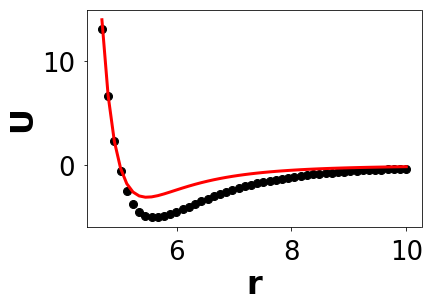

In [7]:
matched_potential = np.array([optimization.forcefield.calc_potential(r) for r in separations])

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, matched_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

As we can see from the plot above, the optimization did a pretty poor job when optimizing three parameters at once.  However, the value of `sigma` was optimizated correctly.  Here we have demonstrated the need for two optimizations.  One where three parameters are allowed to change and the value of `sigma` is optimized, and a second where sigma is fixed at the optimized value and the remaining values are allowed to change.

In [8]:
optimization.forcefield.sigma.fixed = True

second_optimization = Optimization(optimization.forcefield, system, target, configurations=1, verbose=True)
second_optimization.driver()

##############################################
Setup: Checking root problem for potential issues...

No recorders have been specified, so no data will be saved.

Setup: Check of root problem complete.
##############################################

Current values:
n:	18.559303202985237
epsilon:	3.05341352291578
Residual:	0.24942753797926517

Current values:
n:	18.559303202985237
epsilon:	3.05341352291578
Residual:	0.24942753797926517

Current values:
n:	27.838954804477858
epsilon:	3.05341352291578
Residual:	0.35315930253803707

Current values:
n:	18.559303202985237
epsilon:	4.58012028437367
Residual:	0.15375098622276173

Current values:
n:	11.738097985544078
epsilon:	5.615211975354927
Residual:	0.06758387101077308

Current values:
n:	9.04837150695344
epsilon:	7.0763794303094
Residual:	0.20892560713312847

Current values:
n:	7.977712758403509
epsilon:	5.16804234041951
Residual:	0.1253128293861511

Current values:
n:	13.877409899110253
epsilon:	5.467568689743873
Residual:	0.0527097402195

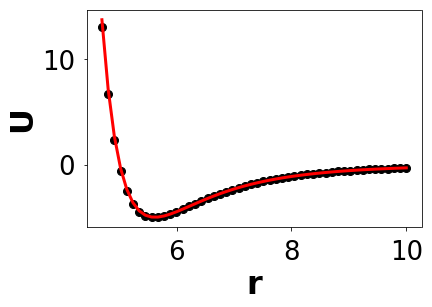

In [9]:
matched_potential = np.array([second_optimization.forcefield.calc_potential(r) for r in separations])

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, matched_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

The plot above shows that we were able to recover the `epsilon` and `n` values with the second optimization.